In [1]:
# imports
import torch
import InferPSF
import numpy as np
from astropy.io import fits
import os
import sys
from scipy.signal import convolve2d as conv
from scipy.special import i1 # modified bessel function of order 1
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

PyTorch version: 1.6.0


In [2]:
## Specify a few useful functions ##
def convert_to_tensor(data):
    # converts np array to F32 tensor
    data = data.astype(np.float32)
    data = np.array([[data]])
    tensor = torch.from_numpy(data)
    return tensor

def crop(image, crop_size):
    # symmetric crop around image border
    return image[crop_size:image.shape[0]-crop_size, crop_size:image.shape[1]-crop_size]

## save results
def save_numpy_as_fits(numpy_array, filename):
    hdu = fits.PrimaryHDU(numpy_array)
    hdul = fits.HDUList([hdu])
    hdul.writeto(filename, overwrite=True)

##################################################################################################
## as implemented in Salahat et al. 2013 for approximating the modified Bessel function of the first kind

coeffs = torch.Tensor([[0.1682, 0.7536, 0.2667, 0.4710, 0.1121, 0.9807, 2.41e-9, 1.144],
                   [0.1472, 0.9739, 0.4916, -163.40, 0.1055, 0.8672, 0.06745, 0.995],
                   [0.4450, -0.715, 0.1110, 0.9852, -0.00018, 1.0795, 0.05471, 0.5686],
                   [0.2382, 0.2343, 0.1304, 0.8554, 0.00326, 1.0385, 0.07869, 0.946]])

#coeffs = coeffs.to(device)

def I1_vectorised(argument, coeffs):

        z0 = argument[argument >= 0]
        z0 = z0[z0 <= 11.5]
        z0 = z0.reshape(len(z0), 1)

        z1 = argument[argument > 11.5]
        z1 = z1[z1 <= 20]
        z1 = z1.reshape(len(z1), 1)

        z2 = argument[argument > 20]
        z2 = z2[z2 <= 37.25]
        z2 = z2.reshape(len(z2), 1)

        z3 = argument[argument > 37.25]
        z3 = z3.reshape(len(z3), 1)

        a0, a1, a2, a3 = coeffs[:,0], coeffs[:,2], coeffs[:, 4], coeffs[:,6]
        b0, b1, b2, b3 = coeffs[:,1], coeffs[:,3], coeffs[:, 5], coeffs[:,7]

        def linalg(z, a, b):
            expz = torch.exp(z @ b.reshape(1, len(b)))
            ab = a*b
            out = expz @ ab
            return out

        out0, out1, out2, out3 = linalg(z0, a0, b0), linalg(z1, a1, b1), linalg(z2, a2, b2), linalg(z3, a3, b3)

        out = torch.cat((out0, out1, out2, out3))

        return out
    

## negative log-likelihood
# EMCCD detector parameters
sigma, f, gain = 60., 25.8, 300. # readnoise, ADU conversion factor, EM gain

def nll(prediction, data, sigma, f, gain, offset):
    
    # collapse everything to 1D
    prediction, data = prediction.flatten(), data.flatten()
    
    # for convenience, sort data, and realign prediciton for the data so that pixel pairs correspond
    data, indices = data.sort()
    prediction = prediction[indices]

    # define 'pi' as a tensor
    pi = torch.from_numpy(np.array(np.pi))
    
    # define offset as tensor
    offset = torch.from_numpy(np.array(offset))
    
    # convert ADU counts to appropriate dimensions
    g = f*(data - offset) # (e-_EM / ADU) * ADU = e-_EM
    n = (f/gain)*prediction # (e-_EM / ADU) * (e-_phot / e_EM) * ADU = e-_phot

    ##### gaussian read noise #####
    pdf_readout = torch.exp(-n) * (1./torch.sqrt(2*pi*sigma**2)) * torch.exp(-0.5*(g/sigma)**2)

    ##### EM gain noise #####
    # only defined for g>0
    g_pos = g[g>0]
    n_pos = n[g>0]

    # require n_pos > 0
    n_pos = torch.clamp(n_pos, min=1e-30)

    # evaluate modified bessel function of first order
    x = 2*torch.sqrt((n_pos*g_pos)/gain)
    bessel = I1_vectorised(x, coeffs)
    
    # EM pdf
    pdf_EM = torch.exp(-n_pos - (g_pos/gain)) * torch.sqrt(n_pos/(g_pos*gain)) * bessel

    # add EM pdf to readout pdf for g>0 pixels
    pdf_pos = pdf_readout[g > 0] + pdf_EM
    pdf_neg = pdf_readout[g <= 0]

    # plug everything back together and compute the log-likelihood
    pdf = f*torch.cat((pdf_neg, pdf_pos)) # convert to 1/ADU = (e-_EM/ADU) * (1/e-_EM)
    
    ll = torch.sum(torch.log(pdf))
    
    return -ll

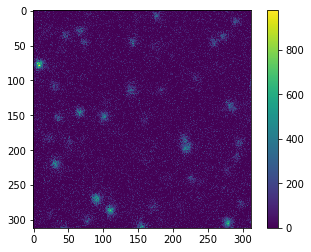

In [3]:
## load LI spool and initial estimate of the scene

# crop images by this much...
crop_size = 100

# cycle through reduction directory
path = '/media/jah94/Seagate_Expansion_Drive#2/Reduction/OGLE_spools_test_2mins'
LI_spool = []
for d, s, files in os.walk(path):
    for file in files:
        #if 'OGLE_000100' in file:
        if 'OGLE_' in file:
            LI_spool.append(file)

#import random
#random.shuffle(LI_spool)
            
#print(LI_spool)
            
# initialise scene with TLI run
tli_scene = fits.getdata(os.path.join(path, 'OGLE-III-BLG101_Llr_2019-07-18_00008.fits'))
scene = crop(tli_scene[0], crop_size) # top 1%, cropped
#frame = fits.getdata(os.path.join(path, 'OGLE_000010.fits'))
#scene = crop(frame, crop_size) # top 1%, cropped

# sky subtract
scene -= np.median(scene)

# positivity
scene[scene < 0] = 0.

## plot initial estimate of scene
s0 = np.copy(scene)
plt.imshow(s0)
plt.colorbar()
plt.show()

In [4]:
# convert scene to tensor
scene = convert_to_tensor(scene)
s0 = np.copy(scene[0][0].numpy())
scene.requires_grad = True # the scene is a parameter

In [7]:
## Tresh!!

list_of_scenes = []
list_of_kernels = []
global_losses = []

for n, image in enumerate(LI_spool):
        
    # 500 updates
    if n < 10000:
        
        print('Image:', n)
    
        # load image and apply crop
        y = crop(fits.getdata(os.path.join(path, image)), crop_size)

        # sky subtract
        #y -= np.median(y)

        # infer 'PSF', differential background and bias offset
        kernel_size = 31

        
        psf, sky, offset, placeholder = InferPSF.DIA(scene,
                                                     y,
                                                     np.ones(y.shape),
                                                     read_noise = 0.,
                                                     ks = kernel_size,
                                                     lr_kernel = 1e-3,
                                                     lr_B = 1,
                                                     Newton_tol = 1e-10,
                                                     poly_degree=0,
                                                     fast=True,
                                                     tol = 1e-5,
                                                     max_iterations = 1000,
                                                     positivity = True,
                                                     show_convergence_plots=True)

        plt.figure()
        plt.title('Inferred PSF')
        plt.imshow(psf, origin='lower')
        #plt.savefig('Inferred_PSF_PGN.png')
        plt.show();

        # convert y and psf to tensors
        y, psf = convert_to_tensor(y), convert_to_tensor(psf)

        ## convolve the scene to match the sky subtracted image
        # prediction = psf*scene + sky (...the bias drift offset enters later)
        prediction = torch.nn.functional.conv2d(scene, psf, bias=None, padding=np.int(((kernel_size - 1)/2))) 
        prediction += torch.tensor(sky)

        # compute the loss (negative log-likelihood)
        loss = nll(prediction, y, sigma, f, gain, offset)
        
        global_losses.append(loss.item())

        # steepest descent - note we update w.r.t to the scene,
        # we update in our parameters!
        dl_ds = torch.autograd.grad(loss, scene)[0]
        
        # step size
        alpha_t = 1e3
        
        ### robust update ###
        #difference =  -alpha_t * dl_ds
        #relative_change = difference / scene
        #dl_ds[torch.abs(relative_change) > 0.5] = 0.
        
        #dl_ds[torch.isnan(dl_ds) == True] = 0.
        
        #plt.imshow(dl_ds[0][0].detach().numpy(), origin='lower')
        #plt.colorbar()
        #plt.show();

        # take a single gradient step
        scene = scene - alpha_t * dl_ds

        # enforce positivity (+ sky subtract)
        with torch.no_grad():
            scene.clamp_(min=0)
            #scene -= torch.median(scene)


        if n % 10 == 0:
            plot_scene = scene[0][0].detach().numpy()

            plt.figure()
            plt.imshow(plot_scene, origin='lower')
            plt.colorbar()
            plt.show();

            plt.figure()
            plt.imshow(plot_scene - s0, origin='lower')
            plt.colorbar()
            plt.show();
            
            list_of_scenes.append(plot_scene)
            list_of_kernels.append(psf)
            
            save_numpy_as_fits(plot_scene, 'SceneEstimates/s_%d.fits' % (n+1))


Image: 0
--- Time to move data onto GPU: 0.0005750656127929688 ---
True
Check dtype of data and weights:
torch.float32 torch.float32 torch.float32 torch.float32
Check size of data and weights:
torch.Size([1, 1, 312, 312]) torch.Size([1, 1, 312, 312]) torch.Size([1, 1, 31, 31]) torch.Size([1])
Starting optimisation
Iteration:0, loss=295263.187500, P=0.000961
Parameter containing:
tensor([2.4853341579], device='cuda:0', requires_grad=True) tensor([1.5000000000], device='cuda:0', requires_grad=True)


KeyboardInterrupt: 

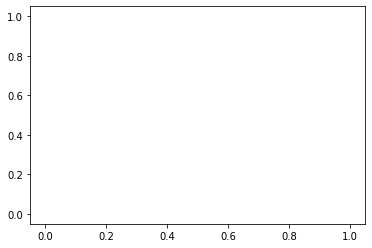

In [8]:
#plt.plot(global_losses)